# Курс по машинному обучению,   ВМК МГУ
## Кластеризация. Методы снижения размерности. Частичное обучение

### Важно! О формате сдачи

* **Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования</font>. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно**
* **В этом ноутбуке есть задание на unit-тестирование**
* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**

**А также..**

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

__В этом задании вы..:__

- Познакомитесь с одним способом визуализации процесса обучения
- Сравните между собой результаты разных способов кластеризации
- Посмотрите и реализуете несколько метрик качества кластеризации
- Попробуете разные методы снижения размерности
- Порешаете задачу на частичное обучение

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

Перед началом выполнения переведите ноутбук в `Доверенный режим` (`Trusted`) для корректного отображения изображений:

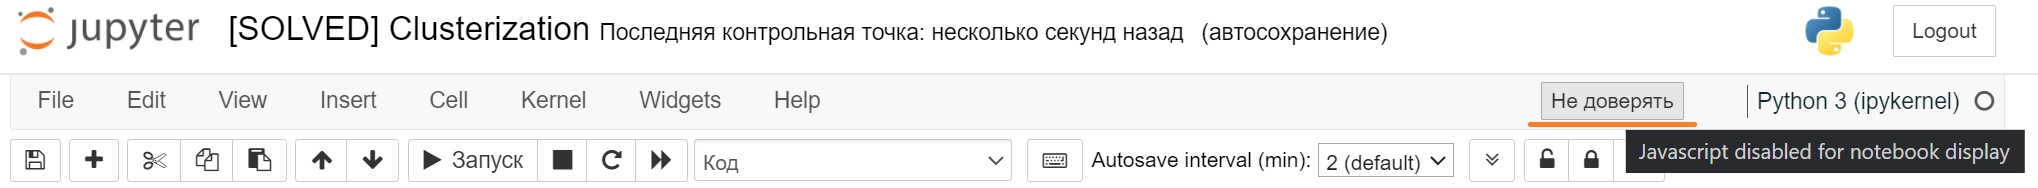

# 0. Введение. [кросспроверка 2 балла]

## 0.1 О задании

В данной работе вам предстоит познакомится с методами машинного обучения без учителя — кластеризацией и алгоритмами снижения размерности. Также будет предложено применить кластеризацию и снижение размерности в задачах Частичного Обучения (Semi-Supervised learning).

В данном задании предлагается три основных части ($1, 2, 3$) и одна вспомогательная ($0$). Сумарное всемя выполнения ноутбука порядка двух часов при выполнении в сервисах `Kaggle`/`Google Colab`. Рекомендуется использовать Kaggle так как в нём корректно работают интерактивные визуализации.

## 0.2 Необходимые библиотеки

Здесь перечислены основные функции и библиотеки, которые могут понадобиться Вам в процессе выполнения задания. Подключение других библиотек возможно, но нежелательно. **Работа каких-либо других библиотек не гарантируется.**

In [6]:
# %%capture
# ! pip install ipympl

In [1]:
import os
import math
import itertools

import warnings

import numpy as np

import tqdm.auto as tqdm

import scipy.spatial.distance

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision
from torchvision.datasets import MNIST, CIFAR10

# Необходима преварительная установка tensorflow
from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import sklearn

from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering

from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier

# Библиотека umap-learn, а не umap
from umap import UMAP
from sklearn.manifold import TSNE, Isomap

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

2022-12-27 00:03:34.533488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 00:03:35.582632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-27 00:03:35.582888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-27 00:03:35.582898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## 0.3 Введение в интерактивные графики jupyter notebook

Jupyter предоставляет широкий диапазон динамических элементов, которые могут помочь при визуализации данных. В этом задании при подборе гиперпараметров для малых наборов данных Вы можете воспользоваться такими инструментами.

Рассмотрим простейший пример использования **виджетов jupyter notebook** на примере подбора гиперпараметров полиномиальной линейной регрессии.

In [2]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from ipywidgets import interactive, fixed, interact_manual, IntSlider, FloatLogSlider, FloatSlider

Сгенерируем обучающую выборку:

In [3]:
x, y = (
    np.linspace(-4, 3, 100), 
    np.sin(np.linspace(-4, 3, 100)) + np.random.normal(loc=0.0, scale=0.5, size=100)
)

Переключим режим работы matplotlib в интерактивный режим:

In [4]:
# %matplotlib notebook
# Используйте эту комманду для корректной работы на Kaggle
# %matplotlib widget

Нарисуем на графике обучающую выборку. Также, создадим линию на графике `line`, которая будет содержать в себе график предсказаний нашей модели:

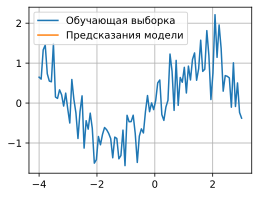

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x, y, label='Обучающая выборка')
line, = ax.plot([], [], label='Предсказания модели')
ax.grid(True)
ax.legend()
plt.show()

Теперь создадим функцию, которая по данным и гиперпараметрам обучит модель, выполнит предсказания и нарисует их на графике:

In [6]:
def polynomial_regression_updater(fig, line, x, y, degree, alpha):
    x_featues = PolynomialFeatures(degree=degree).fit_transform(x.reshape(-1, 1))
    model = Ridge(alpha=alpha, solver='lsqr').fit(x_featues, y)
    
    line.set_xdata(x)
    line.set_ydata(model.predict(x_featues))
    fig.canvas.draw_idle()

Теперь данную функцию можно использовать как callback для использования с динамическими слайдерами для подбора гиперпараметров. `interactive_plot` — переменная, отрисовка которой позволяет использовать динамический контент:

In [7]:
interactive_plot = interactive(
    polynomial_regression_updater, fig=fixed(fig), line=fixed(line), x=fixed(x), y=fixed(y), 
    degree=IntSlider(value=4, min=1, max=20, step=1, description='degree'), 
    alpha=FloatLogSlider(value=0.1, min=-3, max=4, step=0.1, description=r'$\alpha$')
)
interactive_plot

interactive(children=(IntSlider(value=4, description='degree', max=20, min=1), FloatLogSlider(value=0.1, descr…

Бывают случаи, когда невозможно обновить данные прямо на графике и может потребоваться перерисовать график с нуля внутри callback:

In [8]:
def beta_distribution_updater(a, b):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    sns.histplot(np.random.beta(a=a, b=b, size=1000), ax=ax, bins=100)
    ax.set_title('Выборочная гистограмма бета распределения')
    ax.grid(True)
    plt.show()

interactive_plot = interactive(
    beta_distribution_updater,
    a=FloatSlider(value=1.0, min=1e-5, max=10, step=0.1, description=r'$\alpha$'), 
    b=FloatSlider(value=1.0, min=1e-5, max=10, step=0.1, description=r'$\beta$')
)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='$\\alpha$', max=10.0, min=1e-05), FloatSlider(value=…

При этом, полную перерисовку с использованием виджетов можно проводить даже в неинтерактивном режиме:

In [9]:
# %matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [10]:
def normal_distribution_updater(loc, scale):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    sns.histplot(np.random.normal(loc=loc, scale=scale, size=1000), ax=ax, bins=100)
    ax.set_title('Выборочная гистограмма номального распределения $\mathcal{N}(\mu, \sigma)$')
    ax.grid(True)
    plt.show()

interactive_plot = interactive(
    normal_distribution_updater,
    loc=FloatSlider(value=0.0, min=-4, max=4, step=0.1, description=r'$\mu$'), 
    scale=FloatSlider(value=1.0, min=1e-5, max=10, step=0.1, description=r'$\sigma$')
)
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='$\\mu$', max=4.0, min=-4.0), FloatSlider(value=1.0, …

**Задание 0.0 [кросспроверка, 2 балла]** 
* Поиграйтесь с интерактивными графиками. 
* Посмотрите в чём заключается смысл функций [`interactive`, `interact_manual`, `fixed`, `IntSlider`, `FloatLogSlider`](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html). 
* Какие ещё [слайдеры и динамические виджеты бывают](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html)? 
* Как вам кажется, удобный ли это инструмент? 
* Предложите несколько примеров, когда он мог бы ещё пригодиться.

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

**Обратите внимание, что динамическое содержимое может некорректно сохраняться в jupyter notebook. Используйте его только для локальной визуализации. Все графики, необходимые для сдачи задания должны быть статическими. Переход в статический режим происходит с помощью магической команды `%matplotlib inline`.**

**Обязательно убедитесь, что все графики корректно сохранились корректно в ноутбуке перед сдачей в систему.**

In [11]:
%matplotlib inline

## 0.4 Ещё несколько важных замечаний

При выполнении задания запрещено:
1. Менять те seed, которые явно указаны в коде
2. Менять прототипы функций, классов, методов классов
3. Менять константы, используемые для генерации выборок

При оформлении задания обратите внимание на форматирование кода и на оформление графиков:

* Весь код должен быть оформлен в строгом соответствии с [PEP8](https://pep8.org/)

Графики должны быть с одной стороны понятными и информативными, а с другой стороны *красивыми*. Вот несколько пунктов, которые помогут удовлетворить этим требования:
1. Все графики должны быть отрисованы в векторном формате. Обратите внимание, что смена режима графиков с динамического на статический и обратно может приводить к сбросу параметров отрисовки графиков. Переход в векторный режим можно выполнить с помощью команды `matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')`
2. На всех графиках без исключения должна быть нарисована сетка
3. Все графики и группы графиков должны иметь заголовок (`title`)
4. При необходимости оси должны быть подписаны
5. Если на графике отображено несколько сущностей (линии/точки/bar разных цветов, формы и так далее), то необходима исчерпывающая легенда
6. Все линии на графиках должны быть чётко видны (нет похожих цветов или цветов, сливающихся с фоном и так далее)
7. Масштаб по каждой оси на графике должен быть выбран правильно. Используйте масштабы `log`, `symlog` по необходимости
8. Если отображена величина, имеющая очевидный диапазон значений (например, проценты могут быть от 0 до 100), то желательно масштабировать ось на весь диапазон значений (исключением является случай, когда вам необходимо показать малое отличие, которое незаметно в таких масштабах)
9. Частота отметок по каждой оси должна быть тщательно подобрана, по необходимости задавайте `[xy]ticks`, `[xy]ticklabels` вручную. Подписи тиков на осях не должны сливаться как на одной оси, так и между ними
10. Помните, что matplotlib умеет выполнять [рендеринг Latex](https://matplotlib.org/stable/gallery/text_labels_and_annotations/tex_demo.html). Используйте эту возможность для написания формул в заголовках, легенде и в подписях осей
11. Используйте *красивую* цветовую палитру с хорошо различимыми цветами. Примеры цветовых палитр можно посмотреть [здесь](https://matplotlib.org/stable/gallery/color/colormap_reference.html). При наличи особенностей восприятия цвета можно использовать специальные палитры:
```python
plt.style.use('seaborn-colorblind')
# Или
plt.style.use('tableau-colorblind10')
# Затем, при отрисовке графиков не используйте параметр cmap
```
12. Графики должны быть не супер-микро и не супер-макро по размерам, так, чтобы можно было увидеть все, что нужно

# 1. Кластеризация на синтетических данных. [кросспроверка 8 баллов,  unittests 10 баллов]

В данной части мы рассмотрим несколько наборов синтетических данных и сравним как разные алгоритмы кластеризации ведут себя в низкоразмерных и высокоразмерных пространствах

## a. Двумерные данные

In [12]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

Сгенерируем двумерные данные с $4$ естественными кластерами разного размера и плотности.

In [13]:
data_moons, labels_moons = make_moons(n_samples=300, shuffle=True, noise=0.09, random_state=None)
data_moons, labels_moons = data_moons[labels_moons == 0], labels_moons[labels_moons == 0]

data_blobs, labels_blobs = make_blobs(
    n_samples=500, n_features=2, centers=[(0, -0.2), (-1.5, -1.5), (-1.5, 1.5)], 
    cluster_std=[0.2, 0.4, 0.6], center_box=[-10.0, 10.0], 
    shuffle=True, random_state=None, return_centers=False
)

data = np.concatenate([data_moons, data_blobs])
labels = np.concatenate([labels_moons, labels_blobs + 1])

In [14]:
def plot_2d_data(data, labels, title='Исходные данные', cmap='tab20', ax=None):
    '''
    Отрисовка 2d scatter plot. 
    :param np.ndarray data: 2d массив точек
    :param Union[list, np.ndarray] labels: список меток для каждой точки выборки
    :param str title: Заголовок графика
    :param str cmap: Цветовая палитра
    :param ax Optional[matplotlib.axes.Axes]: Оси для отрисовки графика.
        Если оси не заданы, то создаётся новая фигура и сразу же происходит её отрисовка
        Иначе, график добавляется на существуюущие оси. Отрисовки фигуры не происходит
    '''
    n_clusters = len(np.unique(labels))
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig = None
        
    scatter = ax.scatter(
        data[:, 0], data[:, 1], c=labels, 
        cmap=plt.get_cmap(cmap, n_clusters)
    )

    cbar = plt.colorbar(scatter, label='Номер кластера', ax=ax)
    cbar.set_ticks(np.min(labels) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
    cbar.set_ticklabels(np.unique(labels))

    ax.set_title(title)
    ax.grid(True)
    
    if fig is not None:
        fig.tight_layout()
        plt.show()

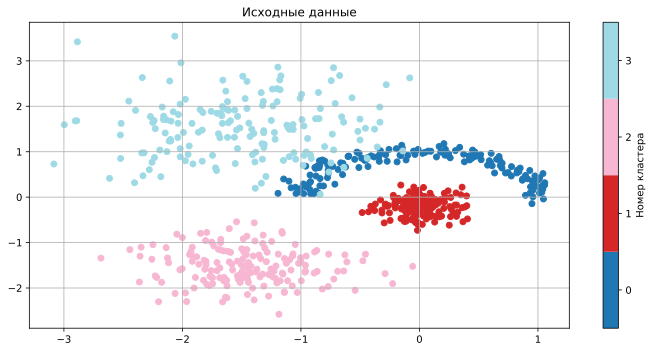

In [15]:
plot_2d_data(data, labels, title='Исходные данные', cmap='tab20')

**Задание 1.a.1 [кросспроверка, 1 балл]** Запустите следующие алгоритмы кластеризации на данной выборке: `KMeans`, `DBSCAN`, `AgglomerativeClustering`. Визуально подберите наилучшие параметры для этих алгоритмов (`n_clusters`, `eps`, `min_samples`, `linkage`). Изобразите наилучшие получившиеся разбиения на графиках.

*Советы:*
1. Используйте виджеты для подбора ручного параметров
2. Используйте `plot_2d_data` для отрисовки графиков. Обязательно меняйте заголовок

In [16]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 1.a.2 [кросспроверка, 1 балл]** Основываясь на знании о работе данных алгоритмов, объясните, почему кластеры были сформированы таким образом. Какой алгоритм лучше всего работает на предложенных данных?

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

## b. Многомерные данные. Снижение размерности

Теперь попробуем кластеризовать данные в высокоразмерном пространстве. Существенным отличием от двумерного случая является невозможность прямой визуальной оценки кластеризации.

Одним из наглядных способов оценки кластеризации является снижение размерности. В данной части вам предлагается использовать алгоритм `TSNE` для визуализации данных.

In [17]:
data, labels = make_classification(
    n_samples=1000, n_features=200, n_informative=100,
    n_repeated=0, n_classes=5, n_clusters_per_class=2, weights=None, 
    flip_y=0.01, class_sep=2.5, hypercube=True, shift=0.0, scale=1.0, 
    shuffle=True, random_state=None
)

**Задание 1.b.1 [кросспроверка, 1 балл]** Примените алгоритм `TSNE` для снижения размерности до двух. Учтите, что `TSNE` суть есть метрический алгоритм и существенно зависит от масштаба признаков — некорректный и различающийся масштаб признаков гарантированно приведёт к неинтерпретируемым результатам. Можете попробовать подобрать гиперпараметры алгоритма для получения лучшей визуализации.

Изобразите получившиеся низкоразмерные вектора. Получилось ли сохранить кластеры при переходе в низкоразмерное пространство?

In [18]:
# Ваш код здесь:＼(º □ º l|l)/

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

**Задание 1.b.2 [кросспроверка, 1 балл]** Примените алгоритмы кластеризации из предыдущего пункта к новым данным. Изобразите получившиеся кластеры в векторном пространстве, полученном с помощью `TSNE`. Не забудьте подобрать оптимальные параметры (те же, что и в пункте **1.a.1**) для всех алгоритмов. Помните, что большинство алгоритмов кластеризации также являются метрическими и существенно зависят от масштаба признаков.

*Замечание:* Обратите внимание, что применять алгоритмы кластеризации нужно к высокоразмерным векторам, а низкоразмерные вектора необходимо использовать только для визуализации.

In [19]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 1.b.3 [кросспроверка, 1 балл]** Опишите получившиеся результаты. Все ли алгоритмы одинаково хорошо разделяют данные?

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

## c. Методы оценки кластеризации. Внутренние и внешние метрики.

Визуальная оценка кластеризации при работе с высокоразмерными данными затруднительна, так как существенно зависит от выбранного метода снижения размерности, который может плохо работать на конкретных данных. С другой стороны, визуальная оценка — субъективна. Поэтому необходимы численные оценки качества кластеризации. 

В данном разделе вам нужно будет реализовать две метрики кластеризации и проверить их на практике.

Существует два основных подхода к оценке кластеризации — внутренние и внешние метрики. Первые используют только информацию о векторах-признаках объектов и метки кластеров, полученные из алгоритма кластеризации. Внешние же, используют информацию об истинной разметке объектов.

### Silhouette

Метрика `силуэт` является классическим представителем внутренних метрик кластеризации. Её суть заключается в оценке двух параметров, характеризующих выделенные кластеры — компактность и отделимость.

Положим, что $C_{i}$ — номер кластера для объекта $i$.

$s_{i}$ — компактность кластеризации объекта $i$ определяется как среднее расстояние от него до всех объектов того же кластера: 
$$s_{i} = \frac{1}{|\{j : C_{j} = C_{i}\}| - 1} \sum\limits_{j : C_{j} = C_{i}} || x_{i} - x_{j} ||$$

$d_{i}$ — отделимость кластеризации объекта $i$ определяется как среднее расстояние от него до всех объектов второго по близости кластера:
$$ d_{i} = \min_{C: C \neq C_{i}} \frac{1}{|\{j : C_{j} = C\}|} \sum\limits_{j : C_{j} = C} || x_{i} - x_{j} || $$

Тогда силуэт объекта $i$:
$$\text{sil}_{i} = \frac{d_{i} - s_{i}}{\max(d_{i},s_{i})}$$

И, наконец, коэффициент силуэта для выборки определяется как среднее силуэтов объектов:
$$S = \frac{1}{|X|}\sum\limits_{i} \text{sil}_{i}$$

Если кластер состоит из одного объекта, то его силуэт равен нулю.

**Задание 1.с.1 [unittests, 5 баллов]** Реализуйте вычисление коэффициента силуэта для заданного разбиения.

При реализации обратите внимание на следующие пункты:
1. При вычислении не должно возникать warning, бесконечностей и nan-ов
2. Используйте не более одного цикла
3. Учтите, что метки кластеров могут идти не по порядку и принимать произвольные значения
4. Если в данных присутствует один кластер, то считайте что силуэт равен 0
5. Если $s_{i} = d_{i} = 0 \Longrightarrow \text{sil}_{i} = 0$
5. Разрешено использовать `sklearn.metrics.pairwise_distances` и аналоги
6. Запрещено использовать любые библиотечные реализации коэффициента силуэта

In [20]:
def silhouette_score(x, labels):
    '''
    :param np.ndarray x: Непустой двумерный массив векторов-признаков
    :param np.ndarray y: Непустой одномерный массив меток объектов
    :return float: Коэффициент силуэта для выборки x с метками labels
    '''
    
    # Ваш код здесь:＼(º □ º l|l)/
    
    return sil_score

**Задание 1.c.2 [кросспроверка, 1 балл]** Посчитайте аналитически коэффициенты силуэта для объектов из примера ниже. Посчитайте силуэт аналитически и сравните его с выводом Вашей функции `silhouette_score`.

*Замечание:* Приведите выкладки с использованием $\LaTeX$. Используйте те же обозначения, что и в теоретической справке выше. Итоговый ответ для силуэта запишите с точностью три знака после запятой.

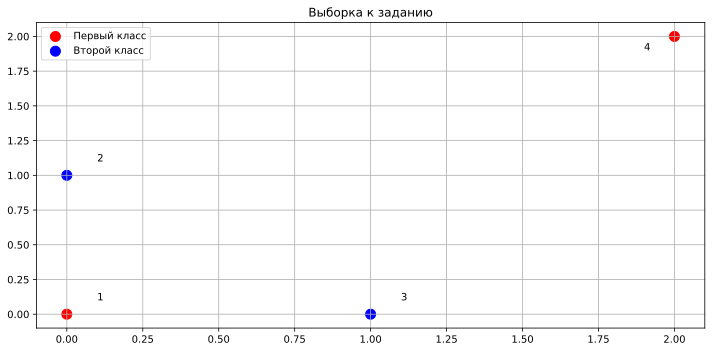

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter([0, 2], [0, 2], s=100, c='r', label='Первый класс')
ax.scatter([0, 1], [1, 0], s=100, c='b', label='Второй класс')

ax.annotate('1', (0.1, 0.1))
ax.annotate('2', (0.1, 1.1))
ax.annotate('3', (1.1, 0.1))
ax.annotate('4', (1.9, 1.9))

ax.set_title('Выборка к заданию')
ax.legend()
fig.tight_layout()
ax.grid(True)
plt.show()

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

In [22]:
# Ваш код здесь:＼(º □ º l|l)/

Убедитесь, что Ваша реализация проходит минимальные тесты: 

In [23]:
assert np.allclose(
    silhouette_score(
        np.array([[0, 0.], [0, 1], [1, 0], [2, 2]]), np.array([1, 0, 0, 1])
    ),
    np.mean([-0.64644661,  0.12596795,  0.12596795, -0.20943058])
)

assert np.allclose(
    silhouette_score(
        np.array([[0, 0.], [0, 1], [1, 0], [2, 2], [1, 1], [2, 0]]), np.array([1, 0, 0, 1, 2, 2])
    ),
    np.mean([-0.64644661,  0.12596795, -0.29289322, -0.39644661, -0.29289322, 0.12596795])
)

NameError: name 'sil_score' is not defined

### B-Cubed

Пусть существует разметка $(y_1, ... , y_l)$, не участвующая в обучении. Мы не использовали эту разметку в качестве дополнительного признака, так как нам не хочется мотивировать модель данным признаком. Тогда предлагается ввести оценку качества алгоритма кластеризации при помощи внешней разметки, саму же разметку тогда называют *gold standard*.

Один из вариантов учесть gold standard разметку — внешняя метрика B-Cubed. Данная метрика позволяет определять следующие особенности кластеризации:
1. **Гомогенность.** Базовое свойство разделения разных объектов в разные кластеры:




2. **Полнота.** Один кластер не должен дробиться на несколько маленьких:



3. **Rag-bag.** Весь мусор должен быть в одном "мусорном"кластере, чтобы остальные кластеры были "чистыми":



4. **Cluster size vs. quantity.** Лучше испортить один кластер с целью улучшить качество множества других:
 

 
Пусть $L(x)$ — gold standard, $C(x)$ — номер кластера, выдаваемый рассматриваемым алгоритмом. 

Рассмотрим несколько величин:
$$
\text{Correctness}(x, x^{\prime}) = \begin{cases}
1 , C(x) = C(x^{\prime}) ∧ L(x) = L(x^{\prime})\\
0 , иначе
\end{cases}
$$
$$
\text{Precision-BCubed} = \underset{x}{\text{Avg}} \underset{x^{\prime}:C(x)=C(x^{\prime})}{\text{Avg}} \text{Correctness}(x, x^{\prime})
$$
$$
\text{Recall-BCubed} = \underset{x}{\text{Avg}} \underset{x^{\prime}:L(x)=L(x^{\prime})}{\text{Avg}} \text{Correctness}(x, x^{\prime})
$$

Тогда, 
$$
\text{B-Cubed} = F_{1} = 2\frac{\text{Precision-BCubed}\times\text{Recall-BCubed}}{\text{Precision-BCubed}+\text{Recall-BCubed}}
$$

**Задание 1.с.3 [unittests, 5 баллов]** Реализуйте вычисление метрики B-Cubed.

При реализации обратите внимание на следующие пункты:
1. При вычислении не должно возникать warning, бесконечностей и nan-ов.
2. Использование циклов запрещено. 
3. Обратите внимание на параметр `where` у функций-агрегаторов в `numpy` ($numpy \geq 1.20.0$).
4. Запрещено использовать любые библиотечные реализации B-Cubed.

In [24]:
def bcubed_score(true_labels, predicted_labels):
    '''
    :param np.ndarray true_labels: Непустой одномерный массив меток объектов
    :param np.ndarray predicted_labels: Непустой одномерный массив меток объектов
    :return float: B-Cubed для объектов с истинными метками true_labels и предсказанными метками predicted_labels
    '''
    
    # Ваш код здесь:＼(º □ º l|l)/
    
    return score

Убедитесь, что Ваша реализация проходит минимальные тесты: 

In [25]:
assert np.allclose(bcubed_score(np.array([1]), np.array([1])), 1.0)
assert np.allclose(bcubed_score(np.array([1]), np.array([2])), 1.0)
assert np.allclose(bcubed_score(np.array([1, 2]), np.array([1, 1])), 2. / 3)
assert np.allclose(bcubed_score(np.array([1, 2]), np.array([1, 2])), 1.0)
assert np.allclose(bcubed_score(np.array([1, 2]), np.array([43, 12])), 1.0)
assert np.allclose(bcubed_score(np.array([1, 1, 2, 2]), np.array([1, 1, 1, 2])), 12. / 17)
assert np.allclose(bcubed_score(np.array([1, 2, 3, 4, 5]), np.array([1, 1, 1, 2, 2])), 4. / 7)

NameError: name 'score' is not defined

**Задание 1.с.4 [кросспроверка, 2 балла]** 
* Для каждого из трёх алгоритмов кластеризации переберите основные параметры (`n_clusters`, `eps`, `min_samples`) и замерьте качество кластеризации с помощью коэффициента силуэта и метрики B-Cubed.
* Для каждого из алгоритмов на одной фигуре изобразите четыре графика — в первой строке два графика с зависимостью коэффициента силуэта и метрики B-Cubed от варьируемого параметра. Во второй строке — визуализация кластеризации с оптимальным параметром, выбранным с помощью первой и второй метрики (можете использовать `plot_2d_data` с параметром `ax`). Для DBSCAN перебирайте оба параметра одновременно и изобразите 2d-heatmap для каждой из метрик. Можете использовать [вспомогательные функции для создания heatmap](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html).
* Совпали ли оптимальные параметры, определённые по этим метрикам? Совпали ли они с теми параметрами которые вы подобрали в предыдущем задании? Предположите почему они совпали/не совпали.
* Можно ли использовать данные метрики для оценки кластеризации между разными алгоритмами? Какая из них лучше отражает качество?

In [26]:
# Ваш код здесь:＼(º □ º l|l)/

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

# 2. Кластеризация "естественных" данных.   [кросспроверка 12 баллов]

Синтетические данные имеют достаточно простую структуру, поэтому методы снижения размерности позволяют получать хорошее низкоразмерное представление с достаточно выраженными кластерами. Однако, реальные данные могут быть устроены существенно сложнее. Посмотрим как поведут себя методы снижения размерности на датасете с картинками CIFAR10.

Загрузим датасет. Будем использовать только часть обучающей выборки, чтобы ускорить вычисления на высокоразмерных данных.

In [27]:
cifar10_test_dataset = CIFAR10('./cifar10', train=False, download=True)
cifar10_train_dataset = CIFAR10('./cifar10', train=True, download=False)

cifar10_labels_test = np.array(cifar10_test_dataset.targets)
cifar10_labels_train = np.array(cifar10_train_dataset.targets)

cifar10_images_test = cifar10_test_dataset.data
cifar10_images_train = cifar10_train_dataset.data

cifar10_images_train, _, cifar10_labels_train, _ = train_test_split(
    cifar10_images_train, cifar10_labels_train, 
    train_size=cifar10_images_test.shape[0], stratify=cifar10_labels_train, random_state=6886
)

cifar10_data_test = (cifar10_images_test.astype(np.float32) / 255.0).reshape([cifar10_images_test.shape[0], -1])
cifar10_data_train = (cifar10_images_train.astype(np.float32) / 255.0).reshape([cifar10_images_train.shape[0], -1])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


Отобразим данные в проекции на две случайные оси. Для удобства воспользуемся здесь ещё одним вариантом динамического контента в jupyter notebook — при наведении на точку на графике будем отображать исходную картинку. 

**После использования динамической визуализации не забудьте вернуться в статический режим и включить векторную графику.**

In [28]:
def plot_interactive(lowd_data, images, labels, names, n_dots=1000):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    n_clusters = len(np.unique(labels))
    
    scatter = plt.scatter(
        lowd_data[:n_dots, 0], lowd_data[:n_dots, 1], s=20, 
        c=labels[:n_dots], cmap=plt.get_cmap('tab20', n_clusters)
    )

    cbar = plt.colorbar(scatter, ax=ax, label='Название кластера')
    cbar.set_ticks(np.min(labels[:n_dots]) + (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters)
    cbar.set_ticklabels(names)
    
    offset_image = OffsetImage(images[0], zoom=2.0)
    ann_bbox = AnnotationBbox(
        offset_image, (0,0), xybox=(50., 50.), xycoords='data',
        boxcoords="offset points", pad=0.3, arrowprops=dict(arrowstyle="->")
    )
    ax.add_artist(ann_bbox)
    ax.set_title('Распределение данных CIFAR10 в проекции на 2 случайные оси')
    ann_bbox.set_visible(False)

    def image_hover(event):
        if scatter.contains(event)[0]:
            ind, *_ = scatter.contains(event)[1]["ind"]
            w, h = fig.get_size_inches() * fig.dpi
            ws = (event.x > w / 2.) * -1 + (event.x <= w / 2.) 
            hs = (event.y > h / 2.) * -1 + (event.y <= h / 2.)
            ann_bbox.xybox = (50.0 * ws, 50.0 * hs)
            ann_bbox.set_visible(True)
            ann_bbox.xy =(lowd_data[ind, 0], lowd_data[ind, 1])
            offset_image.set_data(images[ind])
        else:
            ann_bbox.set_visible(False)
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect('motion_notify_event', image_hover) 
    plt.grid(True)
    plt.show()

In [29]:
%matplotlib notebook

plot_interactive(
    cifar10_data_train[:, [17, 64]], cifar10_images_train, cifar10_labels_train, cifar10_test_dataset.classes, 2000
)

<IPython.core.display.Javascript object>

**Задание 2.1 [кросспроверка, 1 балл]** Воспользуйтесь алгоритмами снижения размерности `TSNE`, `UMAP`, `Isomap`, `KernelPCA` для визуализации картинок. 

Постройте визуализацию низкоразмерного представления, полученного с помощью этих моделей — изобразите четыре графика в одной строке. Во второй строке отобразите результат применения обученных моделей на тестовой выборке. Если для данного алгоритма невозможно сделать предсказания на тестовой выборке — оставьте соответствующий график пустым. Обозначьте разными цветами разные классы объектов. Для повышения производительности можете отобразить только часть выборки на графике (1000-2000 объектов).

*Замечание:* обратите внимание, что все алгоритмы снижения размерности также требуют правильного масштабирования признаков, для корректной работы и интерпретируемых результатов.

In [30]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [31]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 2.2 [кросспроверка, 1 балл]** Опишите увиденное. Почему алгоритмы могли отработать не так, как вы ожидали? 

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

**Задание 2.3 [кросспроверка, 2 балла]** Методы снижения размерности, как и другие метрические методы испытывают трудности при работе с данными высокой размерности. Напишите несколько причин, почему.

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

Один из способов решения этих проблем — перейти в другое, более репрезентативное пространство признаков, где объекты будут расположены в многообразии, которое легче представить в двумерном пространстве. Чтобы выполнить такое преобразование воспользуемся типичным подходом **Transfer Learning** — предобученными нейронными сетями. С помощью глубокой сети обученной на другом наборе изображений (`Imagenet`) мы перейдём в новое векторное пространство и затем применим методы снижения размерности.

In [32]:
FEATURES_PATH = './cifar10_deep_features.npy'

if not os.path.exists(FEATURES_PATH):
    deep_cnn = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))

    cifar10_tensors_test = torch.nn.functional.interpolate(torch.tensor(
        cifar10_images_test.transpose(0, 3, 1, 2)
    ), size=139).numpy().transpose(0, 2, 3, 1).astype(np.float32)
    cifar10_tensors_train = torch.nn.functional.interpolate(torch.tensor(
        cifar10_images_train.transpose(0, 3, 1, 2)
    ), size=139).numpy().transpose(0, 2, 3, 1).astype(np.float32)

    cifar10_deep_features_test = deep_cnn.predict(
        preprocess_input(cifar10_tensors_test)
    ).mean(axis=(1, 2)).reshape([cifar10_tensors_test.shape[0], -1])
    cifar10_deep_features_train = deep_cnn.predict(
        preprocess_input(cifar10_tensors_train)
    ).mean(axis=(1, 2)).reshape([cifar10_tensors_train.shape[0], -1])
    
    np.save(FEATURES_PATH, [cifar10_deep_features_test, cifar10_deep_features_train])
else:
    cifar10_deep_features_test, cifar10_deep_features_train = np.load(FEATURES_PATH, allow_pickle=True)

**Задание 2.4 [кросспроверка, 2 балла]** Используйте выделенные признаки для обучения алгоритмов из предыдущего пункта. Постройте графики. Замечание из пункта **2.1** остаётся в силе.

In [33]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 2.5 [кросспроверка, 2 балла]** 
1. Есть ли какие-то изменения по сравнению с использованием исходных признаков? 
2. Как вы думаете, почему использование глубоких признаков помогло/не помогло в задаче снижения размерности?
3. Какой алгоритм показал себя лучше на ваш взгляд? 
4. Согласованы ли преобразования на обучающей и тестовых выборках? Какие недостатки есть в том, что преобразование на тестовой выборке выглядит отлично от низкоразмерного представления обучающей выборки?
5. Какие из алгоритмов вы бы использовали в качестве первого шага по снижению размерности в задачах машинного обучения?

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

Далее, для визуализации кластеризации используйте один из методов снижения размерности на ваш выбор и то векторное представление, которое лучше всего себя проявило (исходное или полученное с помощью глубокой сети). Кластеризацию обучайте также на наиболее подходящем высокоразмерном векторном представлении.

**Задание 2.6** Изобразите выборку CIFAR10 с помощью выбранного алгоритма снижения размерности.

*Совет*: Изобразите результат с помощью `plot_interactive`, чтобы изучить особенности кластеризации в соответствии с исходными изображениями. Если вы нашли интересные особенности — напишите про это.

In [34]:
# Ваш код здесь:＼(º □ º l|l)/

Теперь, когда мы можем визуализировать кластеризацию, можно сравнить алгоритмы из первой части на естественных данных.

**Задание 2.7 [кросспроверка, 2 балла]** Подберите параметры `KMeans`, `DBSCAN`, `AgglomerativeClustering` используя силуэт и B-Cubed. Визуализируйте получившиеся кластеризации также, как и в задании **1.с.4**. Для ускорения перебора можете производить его на небольшой доле от всех объектов (1000-2000 объектов).

*Замечание:* Алгоритмы кластеризации нужно применять к исходному векторному представлению. Снижение размерности используется только для визуализации. 

In [35]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [36]:
n_objects = 2000

In [37]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 2.8 [кросспроверка, 2 балла]** 
1. Какие алгоритмы справились с кластеризацией естественных данных? 
2. Получилось ли подобрать оптимальное число кластеров с помощью BCubed и коэффициента силуэта?
3. Объясните почему коэффициент силуэта не позволил выполнить подбор оптимальных гиперпараметров.

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

# 3. Частичное обучение.  [кросспроверка 8 баллов,  unittests 5 баллов]

В этой части мы рассмотрим применение алгоритмов снижения размерности и кластеризации в контексте задач классификации в постановке Semi-Supervised learning.

Рассмотрим задачу классификации изображений из датасета MNIST. Предположим, что известна только небольшая часть разметки по которой мы хотим обучить классификатор. В отличии от классических задач обучения с учителем здесь мы можем использовать большой объём неразмеченных объектов.

Будем далее считать, что неразмеченные объекты имеют метку $-1$.

Существует много вариантов решения данной задачи. Предлагается рассмотреть следующие из них:
1. Обучение модели, например, логистической регрессии на размеченной части
2. Методы SelfTraining, в частости `SelfTrainingClassifier` с логистической регрессией в качестве базовой модели
3. Использование кластеризации для определения групп похожих объектов и размеченной подвыборки для определения меток кластеров

Каждый из данных вариантов можно обучать на разных признаковых пространствах. Предлагается проверить, как методы снижения размерности будут влиять на качество итогового алгоритма. Нужно учесть, что не все алгоритмы снижения размерности допускают преобразование новых объектов в низкоразмерное пространство, поэтому предлагается сравнить `UMAP` с исходным признаковым пространством.

**Задание 3.1 [unittests, 5 баллов]** Реализуйте третью из предложенных моделей. 

In [38]:
class KMeansClassifier(sklearn.base.BaseEstimator):
    def __init__(self, n_clusters):
        '''
        :param int n_clusters: Число кластеров которых нужно выделить в обучающей выборке с помощью алгоритма кластеризации
        '''
        super().__init__()
        self.n_clusters = n_clusters
        
        # Ваш код здесь:＼(º □ º l|l)/
        
    def fit(self, data, labels):
        '''
            Функция обучает кластеризатор KMeans с заданным числом кластеров, а затем с помощью 
        self._best_fit_classification восстанавливает разметку объектов
                
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов обучающей выборки
        :param np.ndarray labels: Непустой одномерный массив. Разметка обучающей выборки. Неразмеченные объекты имеют метку -1. 
            Размеченные объекты могут иметь произвольную неотрицательную метку. Существует хотя бы один размеченный объект
        :return KMeansClassifier
        '''
        # Ваш код здесь:＼(º □ º l|l)/
        
        return self
        
    def predict(self, data):
        '''
        Функция выполняет предсказание меток класса для объектов, поданных на вход. Предсказание происходит в два этапа
            1. Определение меток кластеров для новых объектов
            2. Преобразование меток кластеров в метки классов с помощью выученного преобразования
        
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов
        :return np.ndarray: Предсказанные метки класса
        '''
        # Ваш код здесь:＼(º □ º l|l)/
        
        return predictions
    
    @staticmethod
    def _best_fit_classification(cluster_labels, true_labels):
        '''
        :param np.ndarray cluster_labels: Непустой одномерный массив. Предсказанные метки кластеров. 
            Содержит элементы в диапазоне [0, ..., n_clusters - 1]
        :param np.ndarray true_labels: Непустой одномерный массив. Частичная разметка выборки. 
            Неразмеченные объекты имеют метку -1. Размеченные объекты могут иметь произвольную неотрицательную метку.
            Существует хотя бы один размеченный объект
        :return
            np.ndarray mapping: Соответствие между номерами кластеров и номерами классов в выборке, 
                то есть mapping[idx] -- номер класса для кластера idx
            np.ndarray predicted_labels: Предсказанные в соответствии с mapping метки объектов 
            
            Соответствие между номером кластера и меткой класса определяется как номер класса с максимальным числом объектов
        внутри этого кластера. 
            * Если есть несколько классов с числом объектов, равным максимальному, то выбирается метка с наименьшим номером. 
            * Если кластер не содержит размеченных объектов, то выбирается номер класса с максимальным числом элементов в выборке. 
            * Если же и таких классов несколько, то также выбирается класс с наименьшим номером
        '''
        # Ваш код здесь:＼(º □ º l|l)/

        return mapping, predicted_labels

Проверьте `KMeansClassifier._best_fit_classification` на простейших тестах:

In [39]:
def all_equal(list_left, list_right):
    assert np.all([np.all(left == right) for left, right in zip(list_left, list_right)])

all_equal(
    KMeansClassifier(10)._best_fit_classification(
        np.array([2, 2, 2, 1, 1, 1, 0, 0, 0]),
        np.array([5, 5, 6, 8, 7, 6, 6, 7, 7]),
    ),
    (np.array([7, 6, 5, 6, 6, 6, 6, 6, 6, 6]), np.array([5, 5, 5, 6, 6, 6, 7, 7, 7]))
)

all_equal(
    KMeansClassifier(10)._best_fit_classification(
        np.array([ 4,  4,  4, 1, 1, 1, 2, 2, 2, 3, 3, 3,  0, 0,  0, 0,  0]),
        np.array([-1, -1, -1, 5, 5, 6, 8, 7, 6, 6, 7, 7, -1, 8, -1, 3, -1]),
    ),
    (np.array([3, 5, 6, 7, 6, 6, 6, 6, 6, 6]), np.array([6, 6, 6, 5, 5, 5, 6, 6, 6, 7, 7, 7, 3, 3, 3, 3, 3]))
)

NameError: name 'mapping' is not defined

Теперь создадим модель которая будет объединять все вышеописанные способы решения задачи Semi-Supervised learning.

**Задание 3.2** Реализуйте модель, которая в зависимости от параметра `data_processing` будет выполнять то или иное преобразование признакового пространства. Параметр `model` должен задавать одну из трёх описанных выше моделей поверх преобразованных данных. Вспомогательные аргументы нужно передавать через словари `reducer_kwargs`, `model_kwargs` (например, размерность пространства для методов снижения размерности, коэффициент регуляризации логистической регрессии, число кластеров KMeans и так далее).

*Замечание:* Большую часть времени работы модели (как обучения, как и предсказания) будет занимать преобразование признаков в низкоразмерное пространство с помощью UMAP. Если несколько способов, как ускорить данный процесс:
1. Параметр `n_neighbors` у UMAP значательно влияет на скорость работы. Можно установить его меньше, чем по умолчанию (не желательно ставить его меньше 5-7). Попробуйте подобрать этот параметр в зависимости от качества визуализации в задании **3.3**
2. Так как UMAP метрический алгоритм, он требует большого числа вычислений попарных расстояний между точками. При выполнении перебора гиперпараметров в заданиях ниже можно значительно съэкономить, предподсчитав попарное расстояние между объектами для обучения и расстояние между объектам для предсказаний и объектами обучающей выборки. Используйте для работы в таком режиме `metric='precomputed'`. В таком режиме UMAP выдаёт ненужные warnings. Подавите их с помощью соответсвующего контекст менеджера:
```python
with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Вызовы UMAP. __init__ / fit / fit_transform / transform
```
Не забудьте про масштабирование признаков

In [40]:
class MetaSemiSupervisedModel(sklearn.base.BaseEstimator):
    def __init__(self, data_processing, model, reducer_kwargs, model_kwargs):
        '''
        :param str data_processing: 
            Если data_processing == 'UMAP', то входные данные необходимо преобразовать с помощью данного алгоритма с
                числом компонент reducer_kwargs['n_components'].
            Опционально, используйте reducer_kwargs['metric'] для ускорения алгоритма с помощью предподсчитанной
                матрицы расстояний 
            Иначе, не преобразовывать входные данные
        :param str model:
            Если model == 'LogisticRegression', то использовать логистическую регрессию на размеченных данных
                и коэффициентом регуляризации model_kwargs['C']
            Если model == 'SelfTrainingClassifier', то использовать SelfTrainingClassifier с базовой моделью LogisticRegression
                и коэффициентом регуляризации model_kwargs['C']
            Если model == 'KMeansClassifier', то использовать KMeansClassifier с числом кластеров model_kwargs['n_clusters']
        :param dict reducer_kwargs:
        :param dict model_kwargs:
        '''
        super().__init__()
        
        self.model = model
        self.data_processing = data_processing
        self.reducer_kwargs, self.model_kwargs = reducer_kwargs, model_kwargs

        self.scaler = None

        self.model = None
        self.reducer = None

        # Ваш код здесь:＼(º □ º l|l)/

    def fit(self, data, labels):
        '''
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов обучающей выборки. 
            Если reducer_kwargs['metric'] == 'precomputed', тогда @data квадратная матрица попарных расстояний между объектами
        :param np.ndarray labels: Непустой одномерный массив. Разметка обучающей выборки. Неразмеченные объекты имеют метку -1. 
            Размеченные объекты могут иметь произвольную неотрицательную метку. Существует хотя бы один размеченный объект
        :return MetaSemiSupervisedModel
        '''
        # Ваш код здесь:＼(º □ º l|l)/
        
        return self
        
    def predict(self, data):
        '''
        Функция выполняет предсказание меток класса для объектов, поданных на вход
        :param np.ndarray data: Непустой двумерный массив векторов-признаков объектов.
            Если reducer_kwargs['metric'] == 'precomputed', тогда @data прямоугольная матрица расстояний между
            каждым объектом для которого делается предсказание и каждым объектом обучающей выборки.
        :return np.ndarray: Предсказанные метки класса
        '''
        # Ваш код здесь:＼(º □ º l|l)/
        
        return predictions

Загрузим датасет MNIST. Для ускорения перебора гиперпараметров, можете уменьшить число объектов в выборке. Не делайте это число менее $4000$.

In [41]:
mnist_n_objects = 4000

In [42]:
mnist_test_dataset = MNIST('./mnist', train=False, download=True)
mnist_train_dataset = MNIST('./mnist', train=True, download=False)

mnist_labels_test = np.array(mnist_test_dataset.targets)
mnist_labels_train = np.array(mnist_train_dataset.targets)

mnist_images_test = mnist_test_dataset.data.numpy()
mnist_images_train = mnist_train_dataset.data.numpy()

mnist_images_test, _, mnist_labels_test, _ = train_test_split(
    mnist_images_test, mnist_labels_test, 
    train_size=mnist_n_objects, stratify=mnist_labels_test, random_state=6886
)
mnist_images_train, _, mnist_labels_train, _ = train_test_split(
    mnist_images_train, mnist_labels_train, 
    train_size=mnist_n_objects, stratify=mnist_labels_train, random_state=6886
)

mnist_data_test = (mnist_images_test.astype(np.float32) / 255.0).reshape([mnist_images_test.shape[0], -1])
mnist_data_train = (mnist_images_train.astype(np.float32) / 255.0).reshape([mnist_images_train.shape[0], -1])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



**Задание 3.3** Примените метод снижения размерности на ваш вкус для новых данных и изобразите результат на графике. Используйте это представление для визуализации в дальнейшем.

*Замечание:* Не забудьте, что масштаб признаков существенно влияет на работу алгоритма снижения размерности.

In [ ]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 3.4** Разбейте выборку следующим образом:
1. Разбейте случайным образом обучающую выборку на 2 части — размеченную и неразмеченную. Считайте, что доля размеченных объектов — `fraction_of_labeled`. Метки неразмеченной части замените на $-1$.
2. Тестовую выборку разбейте в соотношении $30$ на $70$ — меньшую часть (далее будет называться тестовой выборкой) используйте для подбора гиперпараметров, а большую (валидационная выборка) для итоговой оценки качества.

In [ ]:
fraction_of_labeled = 0.01

In [ ]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 3.5 [кросспроверка, 3 балла]** Используя MetaSemiSupervisedModel подберите оптимальные параметры (`C` (не менее $15$ точек в диапазоне $5-6$ десятичных порядков), `n_clusters` (не менее $10$ точек вплоть до $100$), `n_components` (не менее $7$ точек вплоть до $100$)) для следующих моделей:
1. Исходные признаки + `LogisticRegression`
2. Исходные признаки + `SelfTrainingClassifier`
3. Исходные признаки + `KMeansClassifier`
4. `UMAP` + `LogisticRegression`
5. `UMAP` + `SelfTrainingClassifier`
6. `UMAP` + `KMeansClassifier`

Подбор каждого гиперпараметра должен быть сопровождён графиками точности на тестовой и валидационной выборках. Изобразите обе линии на одном графике.

При переборе обязательно выводите значение найденного оптимального параметра и качество модели с оптимальным гиперпараметром на выборке для итоговой оценки качества.

В последних трёх моделях используйте гиперпараметры базовых моделей, найденные в первых трёх моделях.

In [ ]:
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

**Задание 3.6 [кросспроверка, 2 балла]** Опишите полученные результаты. Какая модель проявила себя лучше всего? Как влияет на результат снижение размерности признакового пространства?

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)

**Задание 3.7 [кросспроверка, 1 балл]** Обучите каждую из шести моделей на выборках с разной долей размеченных объектов. Используйте оптимальные параметры из предыдущего пункта. Изобразите итоговое качество в зависимости от доли размеченных объектов для всех моделей на одном графике. 

Используйте сетку для перебора, указанную ниже. При желании можете взять больше точек.

In [ ]:
fraction_of_labeled_range = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.7, 0.99]

In [ ]:
# Ваш код здесь:＼(º □ º l|l)/

**Задание 3.8 [кросспроверка, 2 балла]** Как разные модели ведут себя в зависимости от объёма размеченных данных? Какой размер выборки достаточно разметить, чтобы получить близкое к максимальному качество?

*Ваш ответ здесь:* (ｏ・_・)ノ”(ノ_<、)